First 5 rows of the data:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

      

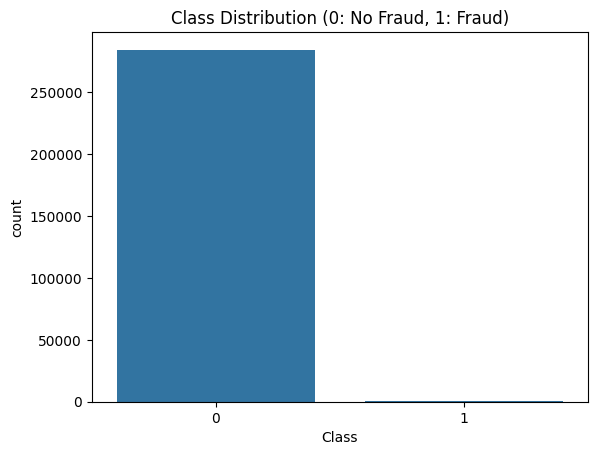

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('data/creditcard.csv')

# --- Initial Exploration ---
print("First 5 rows of the data:")
print(df.head())

print("\nData information:")
df.info()

print("\nStatistical summary:")
print(df.describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum().max()) # Should be 0

# Check the class distribution (very important for fraud detection)
print("\nClass Distribution:")
print(df['Class'].value_counts())

# Visualize the imbalance
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: No Fraud, 1: Fraud)')
plt.show()

In [2]:
# --- Feature Engineering ---

# Scale the 'Amount' and 'Time' columns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['scaled_Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Drop original 'Time' and 'Amount' columns
df = df.drop(['Time', 'Amount'], axis=1)

# Move the 'Class' column to the end for clarity
df.insert(0, 'scaled_Amount', df.pop('scaled_Amount'))
df.insert(1, 'scaled_Time', df.pop('scaled_Time'))

# For simplicity in this guide, we will proceed without creating complex frequency/deviation features.
# In a real-world scenario, you would group by 'CardID' (not present in this dataset)
# and calculate features like:
# 1. Transaction Frequency: Time since last transaction for that card.
# 2. Amount Deviation: (Current Amount - Avg. Amount for card) / Std. Dev for card.
# 3. Geo-location Anomaly: Distance from the last transaction location (requires lat/long).

# Since this dataset is anonymized, the existing V1-V28 features are already powerful.
# We will proceed with these for building a strong baseline model.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
import xgboost as xgb
import joblib

# --- Model Training ---

# Define features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance using 'scale_pos_weight'
# This tells XGBoost to pay more attention to the minority class (fraud)
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

# Initialize and train the XGBoost model
# The 'scale_pos_weight' is crucial for imbalanced data
model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=ratio,
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1
)

print("Training XGBoost model...")
model.fit(X_train, y_train)
print("Model training complete.")

# --- Model Evaluation ---
print("\nEvaluating model performance on the test set...")
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Fraud', 'Fraud']))

# Calculate and print AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score: {roc_auc:.4f}")

# Calculate and print AUPRC (Area Under the Precision-Recall Curve)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
auprc = auc(recall, precision)
print(f"AUPRC Score: {auprc:.4f}") # AUPRC is a better metric for imbalanced data

# --- Save the Model ---
# Create the directory if it doesn't exist
import os
os.makedirs('saved_model', exist_ok=True)

# Save the trained model for later use in the Streamlit app
joblib.dump(model, 'saved_model/xgboost_model.pkl')
print("\nModel saved to saved_model/xgboost_model.pkl")

Training XGBoost model...


c:\Users\vksin\OneDrive\Desktop\fraud-detection-system\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:22:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model training complete.

Evaluating model performance on the test set...

Classification Report:
              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     56864
       Fraud       0.53      0.86      0.66        98

    accuracy                           1.00     56962
   macro avg       0.77      0.93      0.83     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC Score: 0.9755
AUPRC Score: 0.8444

Model saved to saved_model/xgboost_model.pkl
